In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, load_img

2024-12-24 15:31:17.081406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735072277.102286   32438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735072277.108685   32438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 15:31:17.131339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
tf.__version__

In [ ]:
# incrementally use GPU memory as needed instead of allocating all at once
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
def make_model(input_size, learning_rate, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights="imagenet", include_top=False, input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(size_inner, activation="relu")(vectors)
    drop = layers.Dropout(droprate)(inner)
    outputs = layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    return model

In [ ]:
best_size = 100
best_droprate = 0.2
best_lr = 0.001
input_size = 299

In [ ]:
# Define data augmentation layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("vertical"),  # Equivalent to vertical_flip=True
        layers.RandomRotation(0.01),  # Approximation of shear_range
        layers.RandomZoom(height_factor=0.1),  # Equivalent to zoom_range=0.1
    ]
)

In [ ]:
# Load the dataset
train_ds = image_dataset_from_directory(
    "../data/clothing-dataset-small/train",
    image_size=(input_size, input_size),
    batch_size=32,
    label_mode="categorical",
)

train_ds = train_ds.map(
    lambda x, y: (
        data_augmentation(preprocess_input(x)),
        y,
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Load the dataset
val_ds = image_dataset_from_directory(
    "../data/clothing-dataset-small/validation",
    image_size=(input_size, input_size),
    batch_size=32,
    label_mode="categorical",
    shuffle=False,
)

val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [ ]:
# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_final_{epoch:02d}_{val_accuracy:.3f}.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
)

In [ ]:
model = make_model(input_size, best_lr, best_size, best_droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

# Using the model

In [2]:
model = keras.models.load_model("xception_final_11_0.871.keras")
input_size = 299
class_names = [
    "dress",
    "hat",
    "longsleeve",
    "outwear",
    "pants",
    "shirt",
    "shoes",
    "shorts",
    "skirt",
    "t-shirt",
]

I0000 00:00:1735072282.234995   32438 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


a) test data evaluation

In [3]:
# Load the dataset
test_ds = image_dataset_from_directory(
    "data/clothing-dataset-small/test",
    image_size=(input_size, input_size),
    batch_size=32,
    label_mode="categorical",
    shuffle=False,
)

test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)


Found 372 files belonging to 10 classes.


In [4]:
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

I0000 00:00:1735072303.522813   32491 service.cc:148] XLA service 0x793f78003460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735072303.522939   32491 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-12-24 15:31:43.762076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735072304.202634   32491 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 15:31:46.188443: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-24 15:31:48.431125: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran

 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:44 10s/step - accuracy: 0.8438 - loss: 0.4266

I0000 00:00:1735072310.853119   32491 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8492 - loss: 0.4566

E0000 00:00:1735072315.786201   32491 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735072316.011663   32491 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735072316.655928   32491 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735072316.919030   32491 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-24 15:31:58.176935: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.15GiB with freed_by_count=0. The caller indicates that th

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 869ms/step - accuracy: 0.8571 - loss: 0.4348
Test Loss: 0.3148936927318573
Test Accuracy: 0.9005376100540161


b) single image prediction

In [5]:
path = "data/clothing-dataset-small/test/shoes/0dd87e47-ca85-4d5c-9fd1-59f5a01eb656.jpg"
img = load_img(path, target_size=(input_size, input_size))
x = img_to_array(img)
X = tf.expand_dims(x, 0)
X.shape

TensorShape([1, 299, 299, 3])

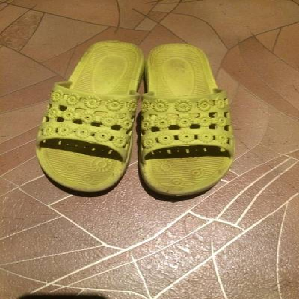

In [6]:
img

In [7]:
X = preprocess_input(X)

In [8]:
pred = model.predict(X)
predicted_class = class_names[tf.argmax(pred[0])]
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'shoes'

In [9]:
dict(zip(class_names, pred[0]))

{'dress': np.float32(-3.3496313),
 'hat': np.float32(-2.0739057),
 'longsleeve': np.float32(-4.15885),
 'outwear': np.float32(-1.2218482),
 'pants': np.float32(1.3345414),
 'shirt': np.float32(-4.927623),
 'shoes': np.float32(14.074381),
 'shorts': np.float32(-0.03065309),
 'skirt': np.float32(-4.898963),
 't-shirt': np.float32(-3.67003)}